# Evaluation Homework

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score

%matplotlib inline

In [5]:
!wget -O homework.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-22 07:23:41--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘homework.csv’

homework.csv        100%[===================>]  78.98K   194KB/s    in 0.4s    

2025-10-22 07:23:42 (194 KB/s) - ‘homework.csv’ saved [80876/80876]



In [6]:
df = pd.read_csv("homework.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Preprocessing

In [7]:
# clean column
df.columns = df.columns.str.lower().str.replace(" ", "_")

df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [12]:
df_num = df.columns[df.columns != "converted"]
categorical = list(df.dtypes[df.dtypes == "object"].index)
numerical = list(set(df.dtypes[df.dtypes != "object"].index).intersection(set(df_num)))
categorical, numerical

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'lead_score',
  'interaction_count',
  'annual_income'])

In [13]:
for i in categorical:
    df[i] = df[i].apply(lambda x:str(x).lower().replace(" ", "_"))

In [21]:
(df[categorical] == "nan").sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [29]:
df[numerical] = df[numerical].fillna(0.0)
df[numerical].isnull().sum()

number_of_courses_viewed    0
lead_score                  0
interaction_count           0
annual_income               0
dtype: int64

In [30]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train)/len(df), len(df_test)/len(df),len(df_val)/len(df)

(0.5991792065663475, 0.20041039671682626, 0.20041039671682626)

In [37]:
X_train = df_train[numerical+categorical]
X_test = df_test[numerical+categorical]
X_val = df_val[numerical+categorical]

y_train = df_train.converted
y_test = df_test.converted
y_val = df_val.converted

## Question 1

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [36]:
to_predict = "converted"
for col in numerical:
    left = df_train[col]
    score = roc_auc_score(df_train.converted, df_train[col])
    print(f"AUC for {col}: {score:.3f}")
    
    if score < 0.5:
        print(f"  -> {col} is negatively correlated, flipping its values.")
        df_loop = df_train.copy()
        df_loop[col] = -df_train[col]
        score = roc_auc_score(df_loop["y"], df_loop[col])
        print(f"  -> New AUC after flipping: {auc:.3f}")


AUC for number_of_courses_viewed: 0.764
AUC for lead_score: 0.614
AUC for interaction_count: 0.738
AUC for annual_income: 0.552


## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [45]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

dict_train = df_train[numerical + categorical].to_dict(orient="records")
X_train = dv.fit_transform(dict_train)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)

dict_val = df_val[numerical+categorical].to_dict(orient="records")
X_val = dv.fit_transform(dict_val)

y_pred = model.predict(X_val)

score = roc_auc_score(y_val, y_pred)

score

0.647564950627936

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [46]:
y_pred = model.predict_proba(X_val)

In [47]:
threshold = np.linspace(0, 1, 50)
threshold

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [54]:
values = []

for t in threshold:
    
    actual_positives = y_val == 1
    actual_negatives = y_val == 0
    
    predict_positive = y_pred[:,1] > t
    predict_negative = y_pred[:,1] <= t
    
    tp = (actual_positives & predict_positive).sum()
    tn = (actual_negatives & predict_negative).sum()
    
    fp = (actual_positives & predict_negative).sum()
    fn = (actual_negatives & predict_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    values.append([t, precision, recall])

/tmp/ipykernel_32790/1942948613.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


In [55]:
df_metric = pd.DataFrame(values, columns=['threshold', 'precision', 'recall'])
df_metric.head()

,threshold,precision,recall
0,0.000000,1.0,0.583618
1,0.020408,1.0,0.583618
2,0.040816,1.0,0.583618
3,0.061224,1.0,0.583618
4,0.081633,1.0,0.583618


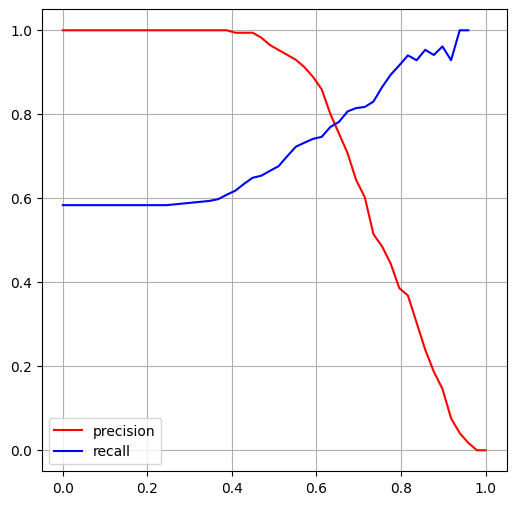

In [56]:
plt.figure(figsize=(6, 6))

plt.plot(df_metric.threshold, df_metric.precision, color="red", label="precision")
plt.plot(df_metric.threshold, df_metric.recall, color="blue", label="recall")

plt.legend()
plt.grid()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$ F_1 = 2* frac{P*R}{P+R} $$

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01



In [59]:
values = []

for t in threshold:
    
    actual_positives = y_val == 1
    actual_negatives = y_val == 0
    
    predict_positive = y_pred[:,1] > t
    predict_negative = y_pred[:,1] <= t
    
    tp = (actual_positives & predict_positive).sum()
    tn = (actual_negatives & predict_negative).sum()
    
    fp = (actual_positives & predict_negative).sum()
    fn = (actual_negatives & predict_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 *((precision*recall)/(precision + recall))
    
    values.append([t, precision, recall, f1_score])

/tmp/ipykernel_32790/4273955432.py:18: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


In [61]:
df_metric = pd.DataFrame(values, columns=["threshold", "precision", "recall", "f1_score"])
df_metric.head()

,threshold,precision,recall,f1_score
0,0.000000,1.0,0.583618,0.737069
1,0.020408,1.0,0.583618,0.737069
2,0.040816,1.0,0.583618,0.737069
3,0.061224,1.0,0.583618,0.737069
4,0.081633,1.0,0.583618,0.737069


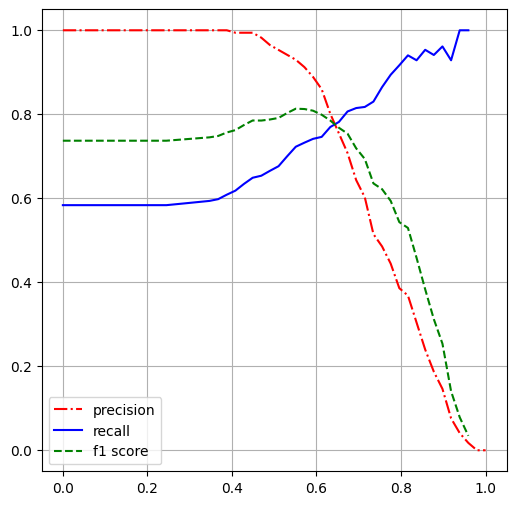

In [64]:
plt.figure(figsize=(6, 6))

plt.plot(df_metric.threshold, df_metric.precision, color="red", label="precision", linestyle="-.")
plt.plot(df_metric.threshold, df_metric.recall, color="blue", label="recall", linestyle="-")
plt.plot(df_metric.threshold, df_metric.f1_score, color="green", label="f1 score", linestyle="--")

plt.legend()
plt.grid()

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

In [66]:
def train(X_train, y_train, C=1.0):
    dicts = X_train[categorical + numerical].to_dict(orient="records")
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [65]:
def predict(df, dv, model):
    
    dicts = df[categorical + numerical].to_dict(orient="records")
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [68]:
from sklearn.model_selection import KFold
from tqdm import tqdm

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("%s %.3f += %.3f"%(C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:05<00:35,  5.95s/it]

0.001 0.867 += 0.045


 29%|██▊       | 2/7 [00:22<01:00, 12.20s/it]

0.01 0.894 += 0.033


/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

0.1 0.916 += 0.023


/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

0.5 0.920 += 0.019


/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

1 0.920 += 0.019


/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

5 0.920 += 0.017


/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mangino/Documents/Projects/MLZoomcamp/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
 

10 0.920 += 0.017
